# Exploratory analysis of the Microbiome Data

<!-- <font color=blue>**Our analysis suggest that MEM the P value from the posterior predictive check analysis is 0.59. Hence, we fail to reject the hypthesis that our model is different from the true model.** </font> -->

In [1]:
## call python script to load data and column order
import os
exec(open('data_file.py').read())
# load packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import copy 
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import kneighbors_graph
from fa2 import ForceAtlas2
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
random.seed(123)
figfol = 'mem_plot/'

plt.rcParams.update(plt.rcParamsDefault)
params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline
distinct_colp = ["maroon","brown","olive", "teal", "lightgreen", "red", "orange",\
 "yellow", "lime", "green", "cyan", "blue", "purple", "magenta",\
 "grey", "pink", "darkorange", "beige", "slategray", "lavender", "navy",\
     "cornflowerblue","olivedrab",'greenyellow','peru','darkslateblue']
# https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
# from fa2 import ForceAtlas2

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


### <font color=blue>**Spatiotemporal location of the samples from the Tara Ocean Expedition survey** </font>

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


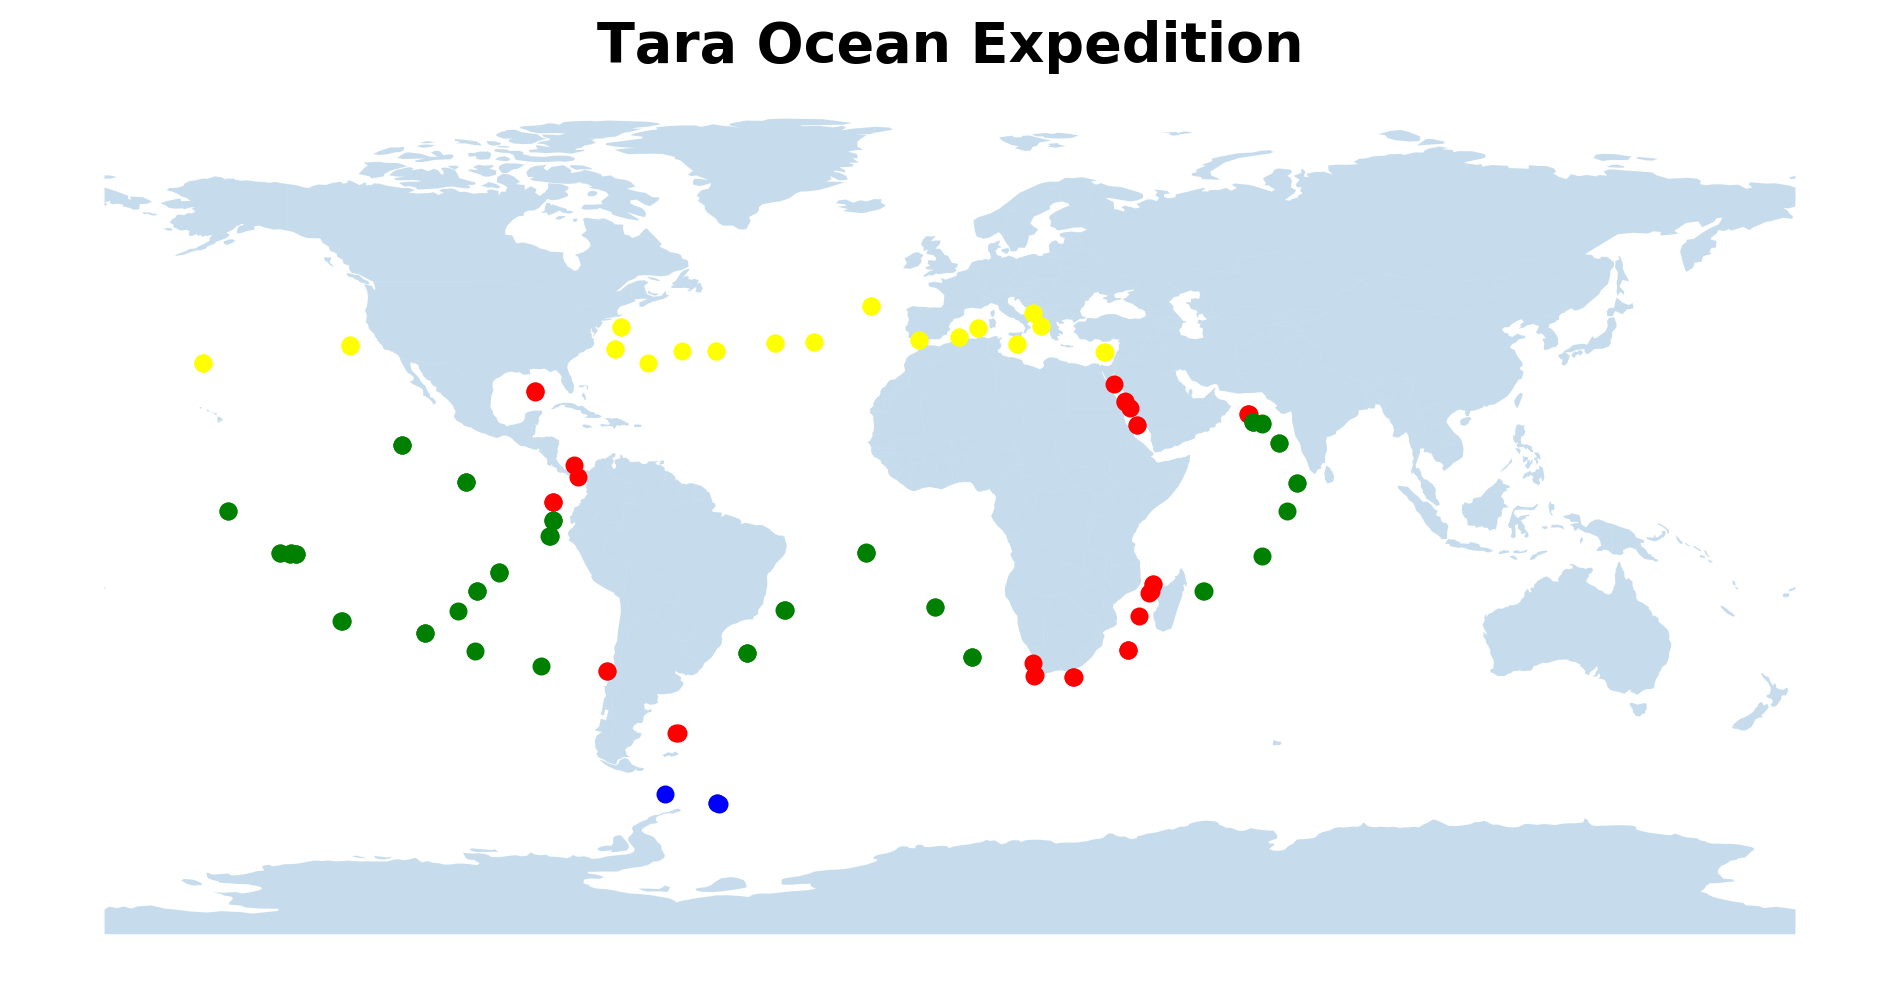

In [2]:
lat_lon = pd.read_csv('geo_loc.csv',index_col = 0)
# !pip install --user geopandas
import geopandas
import matplotlib.pyplot as plt
gdf = geopandas.GeoDataFrame(
    lat_lon, geometry=geopandas.points_from_xy(lat_lon.iloc[:,1],lat_lon.iloc[:,0]))

gdf["Location"] = Z.pelagicBiome_.values
gdf["Depth"] = Z.EnvFeature.values
mark_type = ['o','s', "*", "X"]
mark_dict = {}
for i,j  in enumerate(gdf["Depth"].unique()):
    mark_dict[j] = mark_type[i]
mark_loc = [mark_dict[j] for j in gdf["Depth"]]
gdf["Select"] = 0
gdf["Select"][151] = 1
gdf["Select"][90] = 2

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi = 200)
world.plot(ax=ax, alpha =  0.25)
loc_col = dict(zip(np.unique(gdf['Location']),['red','blue','green','yellow']))
for i in np.unique(gdf['Location']):
    gdf[gdf['Location'] == i].plot(ax=ax, markersize = 30, categorical=True,\
         legend=True, color=loc_col[i], marker = 'o')

# gdf.plot(ax=ax, markersize = 30, column='Location', categorical=True,\
#          legend=True, color=['red','blue'], marker = 'o')
# for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.Select):
#     if label > 0:
#         ax.annotate(label, xy=(x, y), xytext=(10, 0), textcoords="offset points",arrowprops=dict(arrowstyle="simple"), fontsize= 20)
ax.set_title("Tara Ocean Expedition", fontsize=20)
ax.set_axis_off()
fig.savefig(figfol + 'sample_location.png', dpi = 200)

### <font color=blue>**Legend of the province indicator** </font>

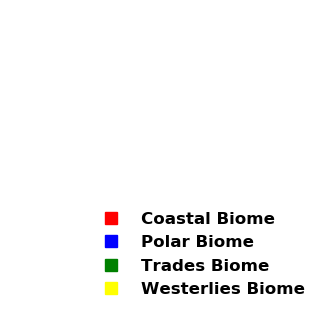

In [3]:
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0] 
fig, ax  = plt.subplots(dpi = 100, figsize = (4,4))
handles = [f("s", loc_col[i]) for i in loc_col.keys()]
plt.legend(handles, list(loc_col.keys()), loc=4, framealpha=1, frameon=False, ncol=1,markerscale=1.5, fontsize=12)
plt.gca().set_axis_off()
plt.show()
fig.savefig(figfol + 'temp.png', dpi = 200)


### <font color=blue>**Geochemical features at the spatial location 1 and 2** </font>


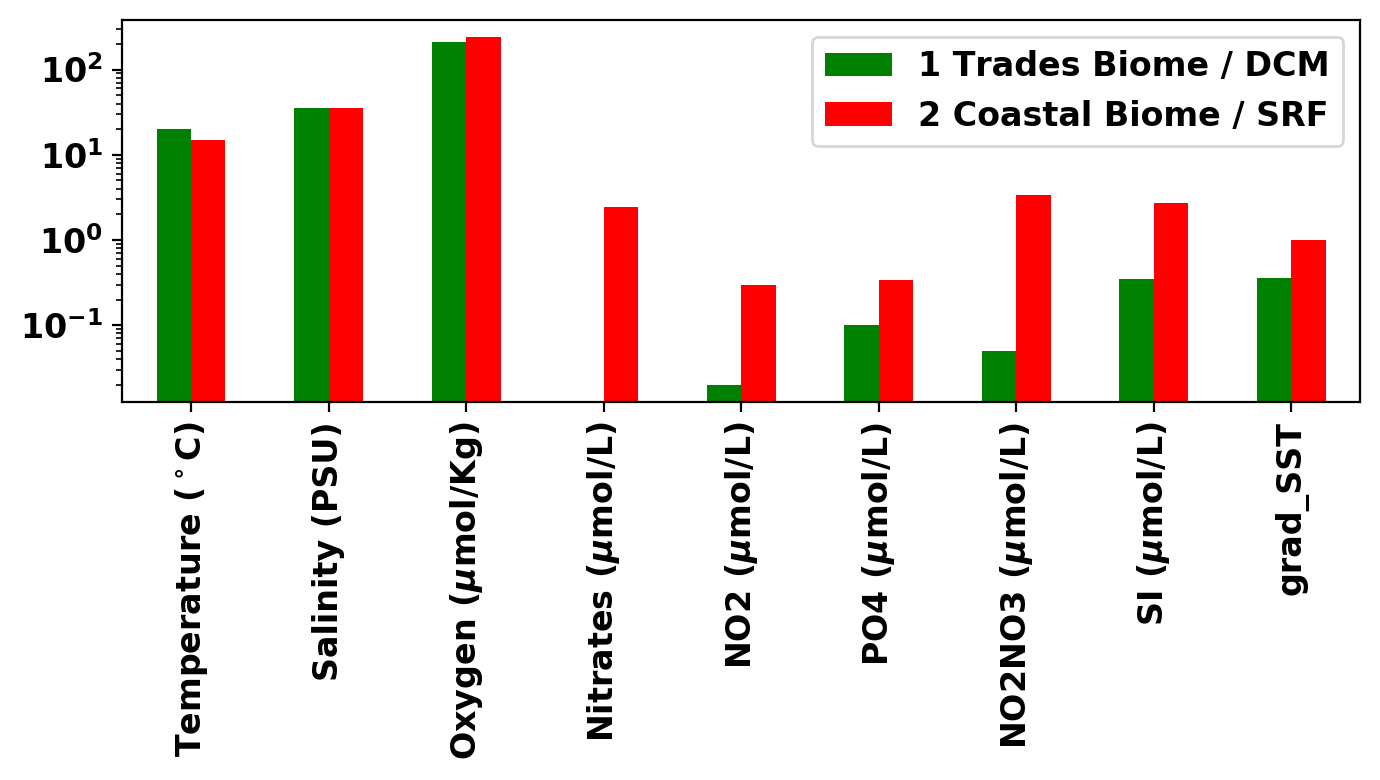

In [4]:
selIndex = np.where(gdf['Select'] > 0)[0]
X1 = pd.read_csv('X_raw.csv').iloc[:,1:]
label_var =  ['Temperature ($^\circ$C)', 'Salinity (PSU)','Oxygen ($\mu$mol/Kg)', 'Nitrates ($\mu$mol/L)', 'NO2 ($\mu$mol/L)', 'PO4 ($\mu$mol/L)', 'NO2NO3 ($\mu$mol/L)', 'SI ($\mu$mol/L)', 'grad_SST']
pl_df = pd.DataFrame(X1.iloc[selIndex,].T).round(2)
pl_df.index = label_var
pl_df.columns = gdf.iloc[selIndex,3:6].apply(lambda x : str(x['Select']) + ' ' + x['Location'].strip() + ' / '+ x['Depth'], axis = 1)
pl_df = pl_df.iloc[:,[1,0]]
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi = 200)
pl_df.plot(kind='bar',log=True, ax = ax, color = ['green','red'])
plt.xticks(fontsize=12, rotation=90)
#ax.set_ylabel('Value (log scale)')
fig.tight_layout()
fig.savefig(figfol + 'sample_location_features.png', dpi = 200)

In [5]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
params = {'legend.fontsize': 8,
          'font.weight': 'bold',
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.labelweight': 'bold',
         'xtick.labelsize':6,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':10}
plt.rcParams.update(params)


### <font color=blue>**Taxonomic composition at the spatial location 1 and 2** </font>


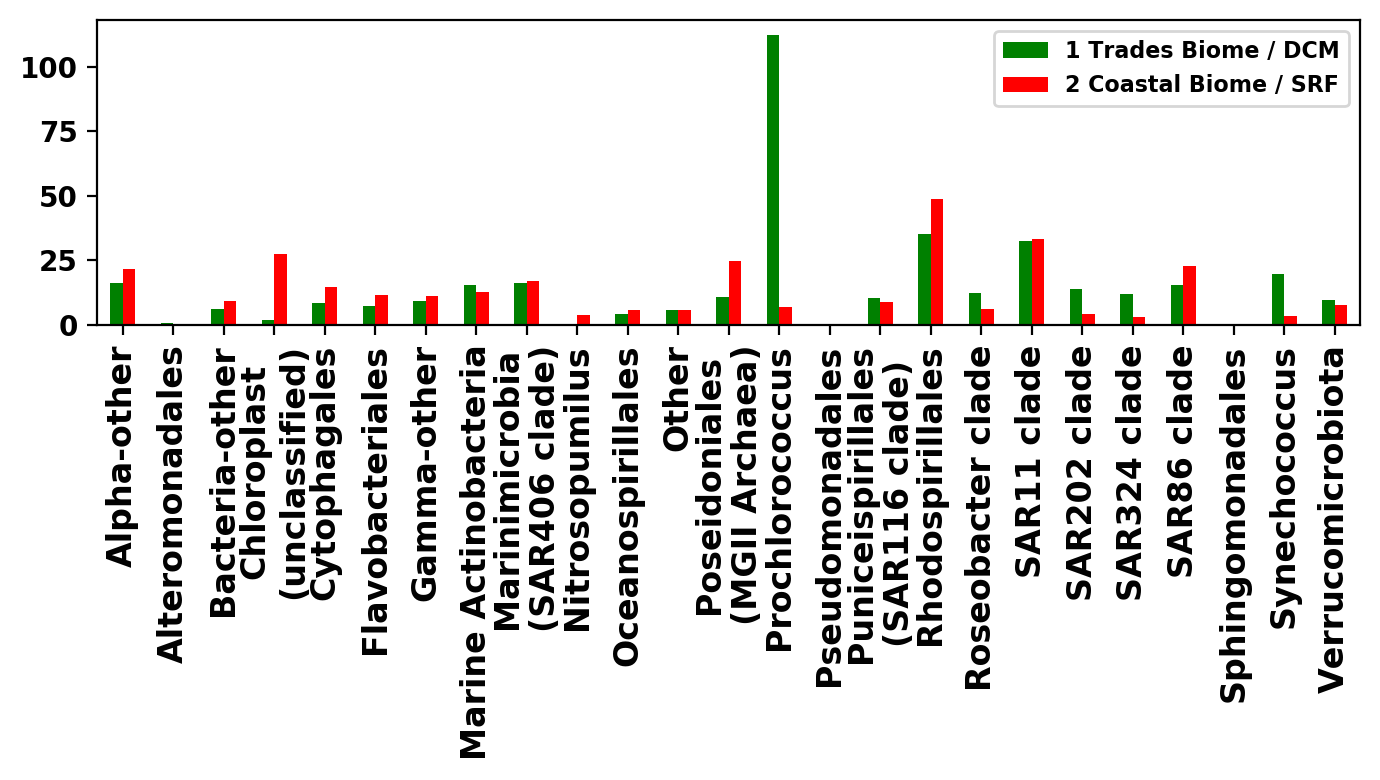

In [7]:
pd.read_csv('Y1.csv')
Yx = pd.read_csv('Y1.csv')  
Yx = Yx.iloc[:,range(2,Yx.shape[1])]
Yx = Yx.astype('int')
pldf = Yx.iloc[selIndex,:].T
pldf.columns = gdf.iloc[selIndex,3:6].apply(lambda x : str(x['Select']) + ' ' + x['Location'].strip() + ' / '+ x['Depth'], axis = 1)
pldf['Label'] = pldf.index
tax_name1 = tax_name.merge(pldf,on = 'Label')
pl_df1 = tax_name1.iloc[:,-3:].groupby('ECR').agg('mean').round(2).iloc[:,[1,0]]
pl_df1.index = [i.replace(' (', '\n(') for i in pl_df1.index]
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi = 200)
pl_df1.plot(kind='bar',log=False, ax = ax, color = ['green','red'])
plt.xticks(fontsize=12, rotation=90)
fig.tight_layout()
fig.savefig(figfol + 'sample_location_abu.png', dpi = 200)

In [8]:
tax_namex = tax_name[['Label','ECR']]
tax_namex['val'] = c_ord
tax_namex.iloc[c_ord,2] = range(Y.shape[1])
# tax_namex = tax_namex.sort_values(["ECR", "val"], ascending = (True, False))
# c_ordx = np.array(tax_namex.index)
selected_species = list(np.unique(tax_name['ECR']))
species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))
tax_namex['Color'] = tax_namex['ECR'].map(species_col_dict)


/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [9]:
sam_namex  = Z[['pelagicBiome_','EnvFeature']]
sam_namex['val'] = r_ord
sam_namex.iloc[r_ord,2] = range(Y.shape[0])
# sam_namex = sam_namex.sort_values(["pelagicBiome_", "val"], ascending = (True, False))
# r_ordx = np.array(sam_namex.index)
sam_namex['Color'] = sam_namex['pelagicBiome_'].map(loc_col)

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



### <font color=blue>**Color coded legend of the ERC indicator of taxa**</font>


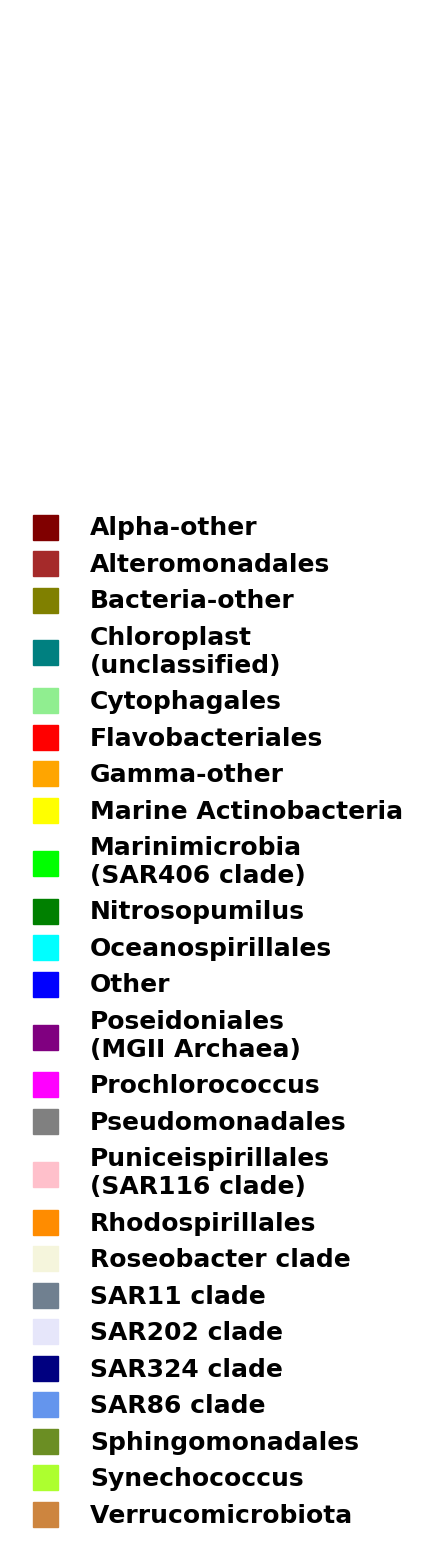

In [10]:
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
label = [i.replace(' (', '\n(') for i in selected_species]  
fig, ax  = plt.subplots(dpi = 100, figsize = (5,20))
handles = [f("s", species_col_dict[i]) for i in selected_species]
plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=1,markerscale=3., fontsize=18)
plt.gca().set_axis_off()
plt.show()
fig.savefig(figfol + 'MI2Anot.png')


### <font color=blue>**Microbial abundance data ordered by ERC (column) and province indicator (row)**</font>


In [11]:
sam_namex = sam_namex.rename(columns = {'Color':'Province'})
tax_namex = tax_namex.rename(columns = {'Color':'ERC'})

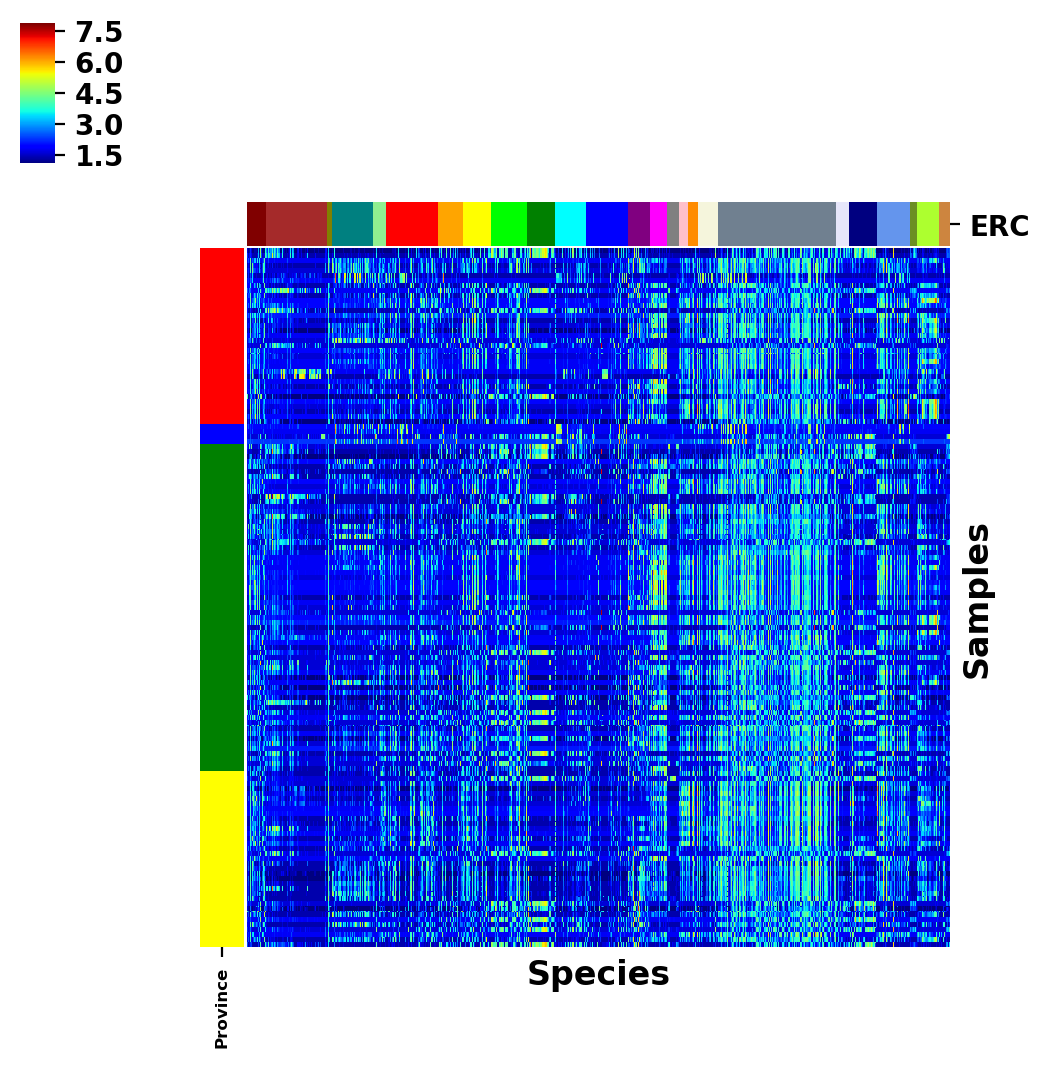

In [12]:
r_or = sam_namex['pelagicBiome_'].argsort().values
c_or = tax_namex['ECR'].argsort().values
tem1 = sam_namex['Province']; 
tem2 = tax_namex['ERC']; 
g = sns.clustermap(np.log(pd.DataFrame(Y).iloc[r_or,c_or]+1),col_cluster = False, row_cluster = False,\
                   cmap="jet",yticklabels=False, xticklabels=False, figsize=(6, 6),\
                   row_colors=tem1, col_colors=tem2)
g.ax_heatmap.set_xlabel('Species', fontsize = 12)
g.ax_heatmap.set_ylabel('Samples', fontsize = 12)
plt.savefig(figfol + 'temp.png', dpi =200, figsize = (20,20))


### <font color=blue>**Hierarchical clustering of the microbial abundandance data** </font>


Note: linkage function of the hierarchical clustering outputs an array of dimension (n-1) times 4, say Z. Number of rows represents the iteration while generating the hierarchical cluster. 

For instance in the ith iteration: node Z[i,0] is merged with node Z[i,1] with distance given by node Z[i,2]. Finally, node Z[i,3] represents the number of distinct nodes. 

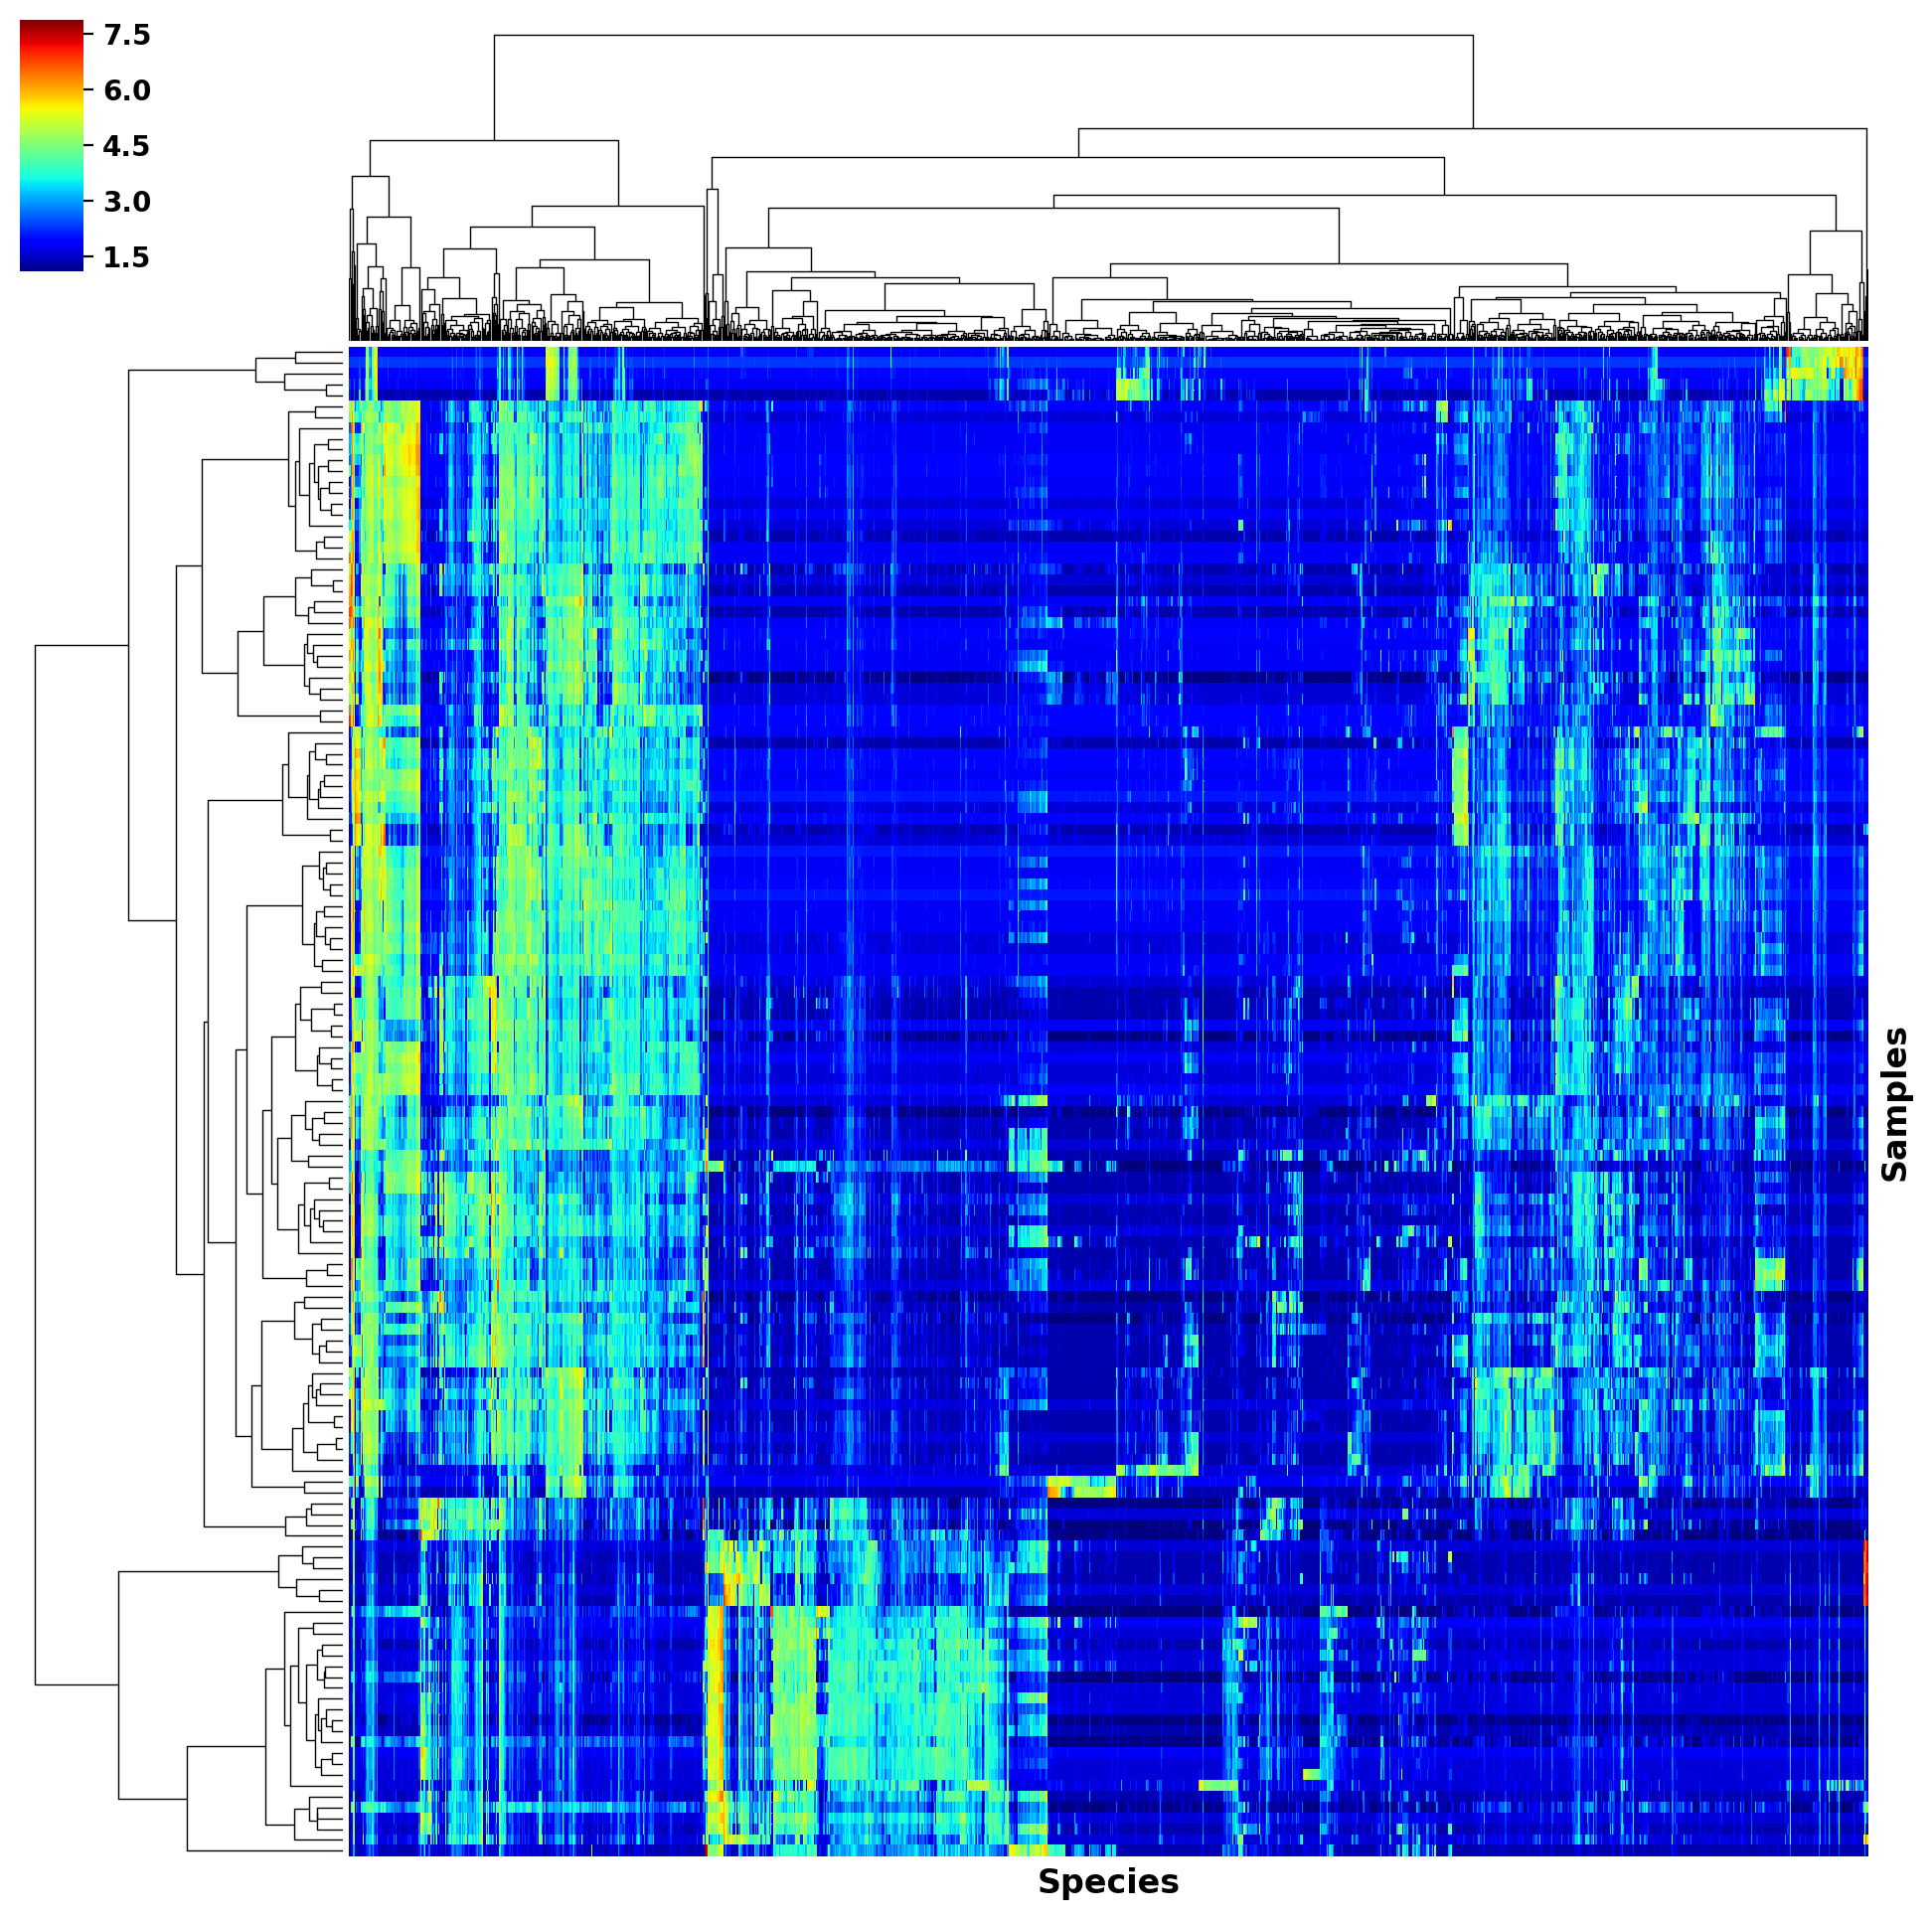

In [13]:
import seaborn as sns; 
np.random.seed(123)
r_ordx = sch.linkage(Y ,metric = 'euclidean',\
                           optimal_ordering = True, method="ward")

c_ordx = sch.linkage(Y.T,metric = 'euclidean',\
                           optimal_ordering = True, method="ward")
sp_ord = sch.leaves_list(c_ordx)

g = sns.clustermap(np.log(Y+1),col_linkage =  c_ordx, row_linkage = r_ordx,\
                   cmap="jet", yticklabels=False, xticklabels=False, figsize=(12, 12))
g.ax_heatmap.set_xlabel('Species', fontsize = 12)
g.ax_heatmap.set_ylabel('Samples', fontsize = 12)
plt.savefig(figfol + 'temp.png', dpi =200, figsize = (20,20))

In [14]:
clust_val = sch.fcluster(c_ordx, t=20, criterion='maxclust')
cIndex, ct = np.unique(clust_val,return_counts = True)
temp = dict(zip(cIndex,ct))

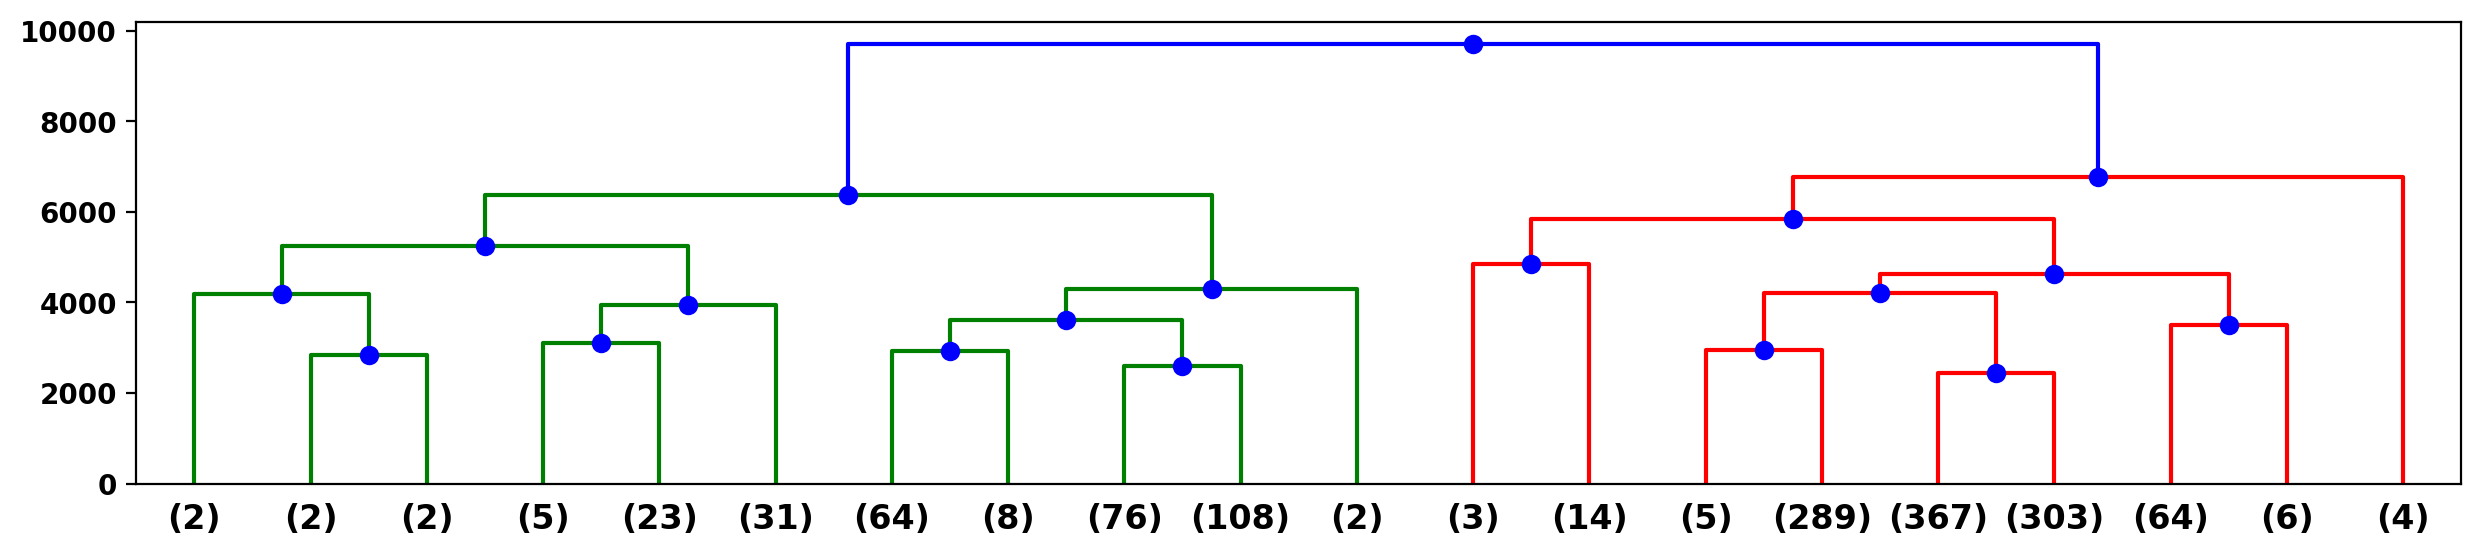

In [15]:
fig, ax  = plt.subplots(dpi = 200, figsize = (15, 3))
dn = sch.dendrogram(c_ordx, p=20, truncate_mode='lastp', ax =ax)
for ind,(i, d) in enumerate(zip(dn['icoord'], dn['dcoord'])):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    plt.plot(x, y, 'bo')
    # plt.annotate(ind, (x, y), xytext=(10,15), textcoords='offset points', va='top', ha='center')    
plt.show()     
fig.savefig(figfol + 'temp.png')

In [16]:
#['C' +str(temp[int(i[1:-1])]) + ': ' + i for i in dn['ivl']]
['C' +str(key) + ': (' + str(value) + ')' for key,value in temp.items()]


['C1: (2)',
 'C2: (2)',
 'C3: (2)',
 'C4: (5)',
 'C5: (23)',
 'C6: (31)',
 'C7: (64)',
 'C8: (8)',
 'C9: (76)',
 'C10: (108)',
 'C11: (2)',
 'C12: (3)',
 'C13: (14)',
 'C14: (5)',
 'C15: (289)',
 'C16: (367)',
 'C17: (303)',
 'C18: (64)',
 'C19: (6)',
 'C20: (4)']


### <font color=blue>**Microbial abundance data ordered by taxa modules and ERC (column)** </font>


In [28]:
#tax_namex.head()
tax_nameN = tax_name[['Label','ECR']]
tax_nameN['val'] = c_ord
tax_nameN.iloc[c_ord,2] = range(Y.shape[1])
# ## Add cluster index in the 
comunity2 = pickle.load(open('ERC_community.pkl', 'rb'))
tem = tax_nameN['Label'].map(comunity2) + 1
clust_col = np.array(['red','blue','green','yellow','grey'])[tem.values-1]
tax_nameN['Cluster'] = clust_col
tax_nameN['COMIND'] = tem
tax_nameN = tax_nameN.sort_values(["COMIND", "val"], ascending = (True, False))
v_indexN = [0]+list(np.where(np.diff(tax_nameN.COMIND.values) > 0)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)
tax_namex = copy.copy(tax_nameN)
tax_namex['ERC'] = tax_namex['ECR'].map(species_col_dict)
# np.unique(tem.values)

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[0, 523, 923, 1230, 1342, 1378]

In [29]:
# clust_val[clust_val <= 11] = 1
# clust_val[(clust_val == 12) | (clust_val == 13)| (clust_val == 14)| (clust_val == 15)] = 2
# clust_val[clust_val == 16] = 3
# clust_val[clust_val == 17] = 4
# clust_val[clust_val >= 18] = 5
# clust_col = np.array(['red','blue','green','yellow','grey'])[clust_val-1]
# tax_namex['Cluster'] = clust_col # [sp_ord]
tax_namex.head()

,Label,ECR,val,Cluster,COMIND,ERC
381,OTU48,Other,1377,red,1,blue
383,OTU132,Marinimicrobia (SAR406 clade),1376,red,1,lime
382,OTU167,Marinimicrobia (SAR406 clade),1375,red,1,lime
380,OTU135,Marinimicrobia (SAR406 clade),1374,red,1,lime
803,OTU71,Chloroplast (unclassified),1373,red,1,teal


In [30]:
#biom_col = dict(zip(np.unique(sam_namex['EnvFeature']),['gray30','gray1','gray49','gray79']))
biom_col = dict(zip(np.unique(sam_namex['EnvFeature']),['#8B8878','#030303','#CDC8B1','#FFF8DC']))
#biom_col = dict(zip(np.unique(sam_namex['EnvFeature']),['#CDC8B1','#8B8878','#EEE8CD','#FFF8DC']))
sam_namex['Biome'] = sam_namex['EnvFeature'].map(biom_col)

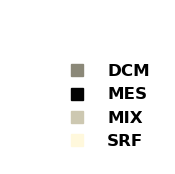

In [31]:
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0] 
fig, ax  = plt.subplots(dpi = 100, figsize = (2,2))
handles = [f("s", biom_col[i]) for i in biom_col.keys()]
plt.legend(handles, list(biom_col.keys()), loc=4, framealpha=1, frameon=False, ncol=1,markerscale=1.5, fontsize=12)
plt.gca().set_axis_off()
plt.show()
fig.savefig(figfol + 'temp.png')

In [32]:
r_color = sam_namex[['Biome','Province']]
c_color = tax_namex[['ERC','Cluster']]

In [ ]:
# g = sns.clustermap(np.log(pd.DataFrame(Y).iloc[r_ord,c_ord]+1),col_cluster = False, row_cluster = False,\
#                    cmap="jet", yticklabels=False, xticklabels=False, figsize=(12, 12),\
#                    row_colors=r_color, col_colors=c_color)
# g.ax_heatmap.set_xlabel('Species', fontsize = 12)
# g.ax_heatmap.set_ylabel('Samples', fontsize = 12)
# g.ax_heatmap.vlines(x=list(np.where(np.diff(clust_val[c_ord]))[0]), ymin = 0, ymax = 1378, lw = 3, linestyles = 'dashed', colors = 'white')
# plt.savefig(figfol + 'temp.png', dpi =200, figsize = (20,20))

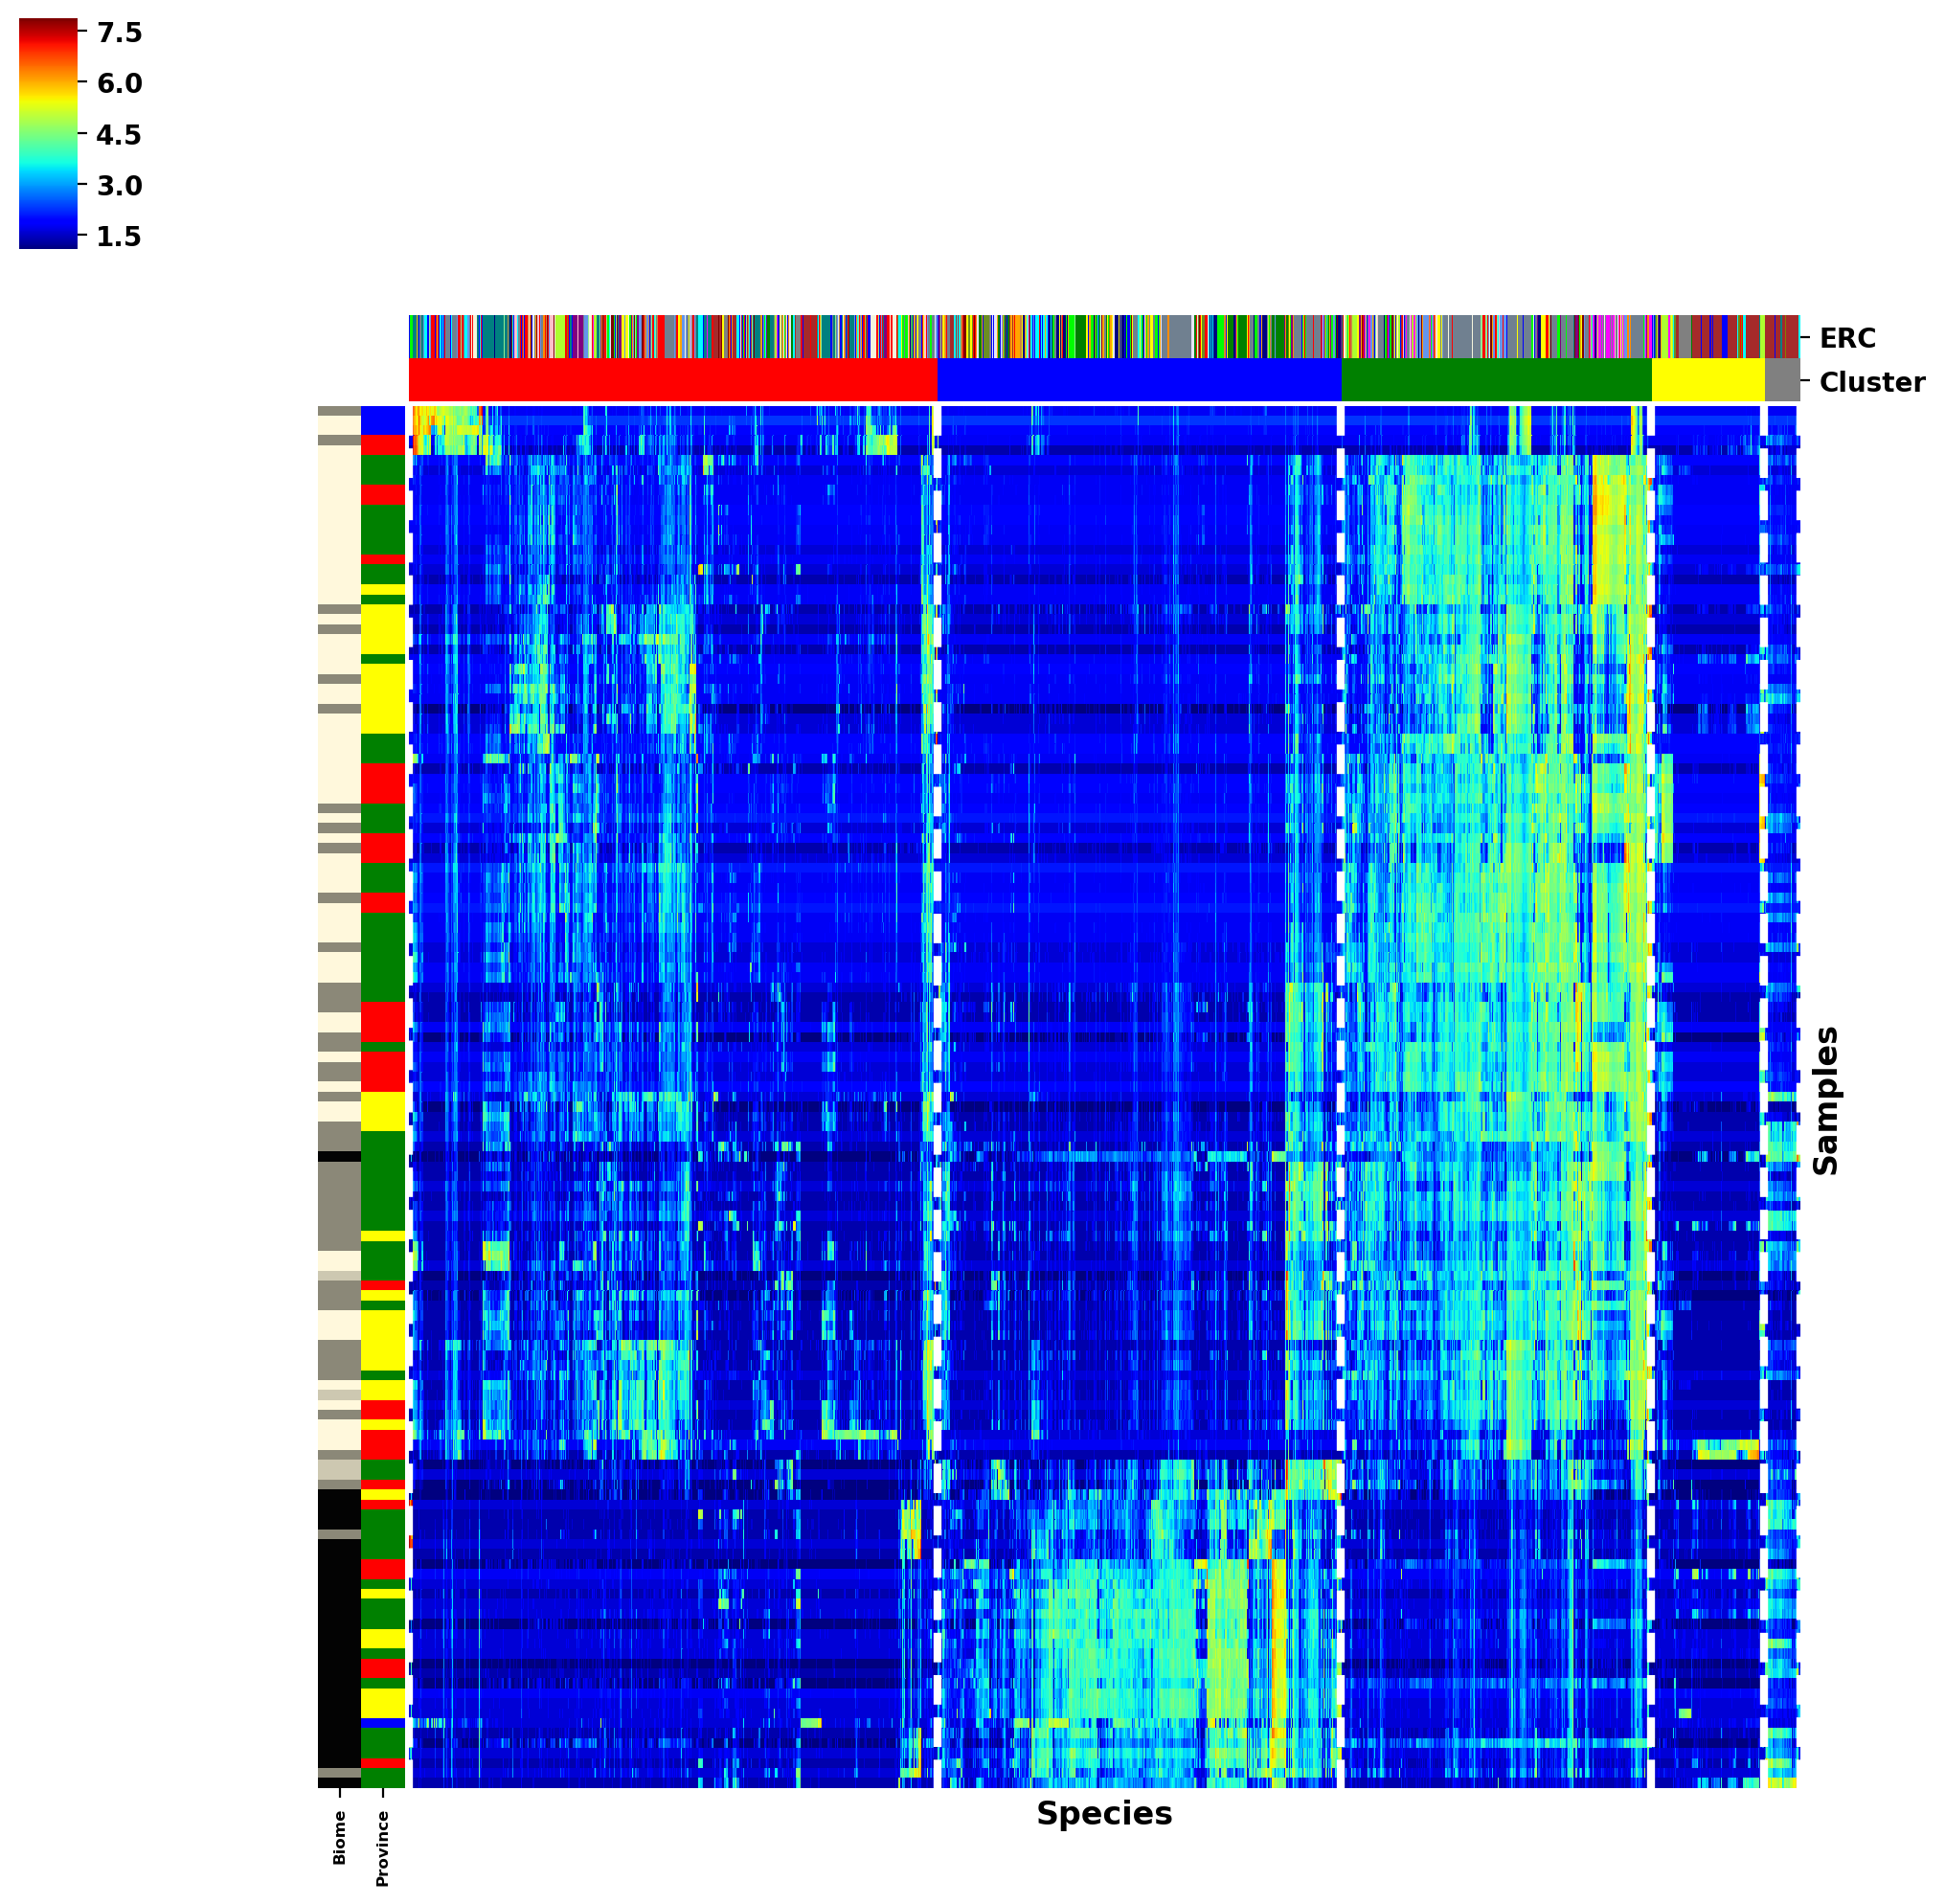

In [35]:
g = sns.clustermap(np.log(pd.DataFrame(Y).iloc[r_ord,c_ordN]+1),col_cluster = False, row_cluster = False,\
                   cmap="jet", yticklabels=False, xticklabels=False, figsize=(12, 12),\
                   row_colors=r_color, col_colors=c_color)
g.ax_heatmap.set_xlabel('Species', fontsize = 12)
g.ax_heatmap.set_ylabel('Samples', fontsize = 12)
g.ax_heatmap.vlines(x= v_indexN, ymin = 0, ymax = 1378, lw = 3, linestyles = 'dashed', colors = 'white')
plt.savefig(figfol + 'temp.png', dpi =200, figsize = (20,20))